# Similarity Matching

In [1]:
# Load Installation
%run setup.py

In [43]:
df_Invited = pd.read_csv(os.path.join(filepath,'factInvited.csv'))
df_Invited['Source'] = "Invited"

df_Proceedings = pd.read_csv(os.path.join(filepath,'factProceedings.csv'))
df_Proceedings['Source'] = "Proceedings"

# # Append data to one dataframe
df = pd.concat([df_Proceedings,df_Invited], sort=False, axis=0)
df = df[df['Productivity'] != 0].reset_index(drop=True)
df['log(Paper Count)'] = np.log(df['Paper Count'])
df['idx'] = df.index

def map_age_group(age_range):
    if age_range >=  20:
        return '>20'
    elif age_range >= 15:
        return '15-20'
    elif age_range >= 10:
        return '10-15'
    elif age_range >= 5:
        return '5-10'
    else:
        return '0-5'
    
df['Age Group'] = df['Age'].apply(map_age_group)

df.head(3)

,Full name,Year,Conference (short),First name,Middle name,Last name,gender,column_equal,Paper Count,Max Paper Count,First year paper,ID,Age,Productivity,Conference (long),Main Topic,Source,log(Paper Count),idx,Age Group
0,Aaron Gage,2004,AAAI,Aaron,NaN,Gage,M,True,7,8,1999,Aaron Gage_1,5,1.400000,AAAI Conference on Artificial Intelligence,Artificial Intelligence,Proceedings,1.945910,0,5-10
1,Abhi Shelat,2004,AAAI,Abhi,NaN,Shelat,M,True,7,75,2002,Abhi Shelat_1,2,3.500000,AAAI Conference on Artificial Intelligence,Artificial Intelligence,Proceedings,1.945910,1,0-5
2,Adele E. Howe,2004,AAAI,Adele,E.,Howe,F,True,48,91,1986,Adele E. Howe_1,18,2.666667,AAAI Conference on Artificial Intelligence,Artificial Intelligence,Proceedings,3.871201,2,15-20


# Similarity on gender

## Define Function

In [35]:
def Nearest_Neighbor(df,k,q,n,print_results):
    df_F = df[df['gender'] == 'F'].reset_index(drop=True)
    df_M = df[df['gender'] == 'M']

    nbrs = NearestNeighbors(n_neighbors=k).fit(df_F[['log(Paper Count)','Productivity','Age']])
    distances, indices = nbrs.kneighbors(df_M[['log(Paper Count)','Productivity','Age']])
    
    # Find threshold
    threshold = np.quantile(distances.flatten(),q=q)
    # plt.hist(distances.flatten(),bins=100)
    # plt.vlines(threshold,0,1000)
    # plt.show()
    mask = distances <= threshold
    if print_results == True:
        print('Threshold',threshold)
        print('Pct. of indices I keep',mask.flatten()[mask.flatten() == True].shape[0] / mask.flatten().shape[0])

    filtered_indices = indices.copy().astype(float)
    filtered_indices[~mask] = np.nan
    
    # Initiliaze ratio list
    ratio_list = []
    
    for i in range(0,n):
        results = df_M.copy()
        results['Similar idx'] = [random.choice(row) for row in indices.tolist()] # select index
        results = results.dropna(subset=['Similar idx'])
        results = results.merge(right = df_F, left_on='Similar idx', right_index=True, how='left',suffixes=['_M','_F']) # merge info
        
        try:
            P_males_inv = results['Source_M'].value_counts(normalize=True).loc['Invited']
            P_females_inv = results['Source_F'].value_counts(normalize=True).loc['Invited']
            ratio = np.divide(P_females_inv,P_males_inv)
            ratio_list.append(ratio)
        except:
            ratio_list.append(np.nan)
            continue
    
    mean_ratio = np.nanmean(ratio_list)
    std_ratio = np.nanstd(ratio_list)
    
    return mean_ratio,std_ratio
    # return ratio_list

## Plot Nearest Neighbor with 1,5 and 10 neighbors

100%|██████████| 20/20 [04:27<00:00, 13.38s/it]


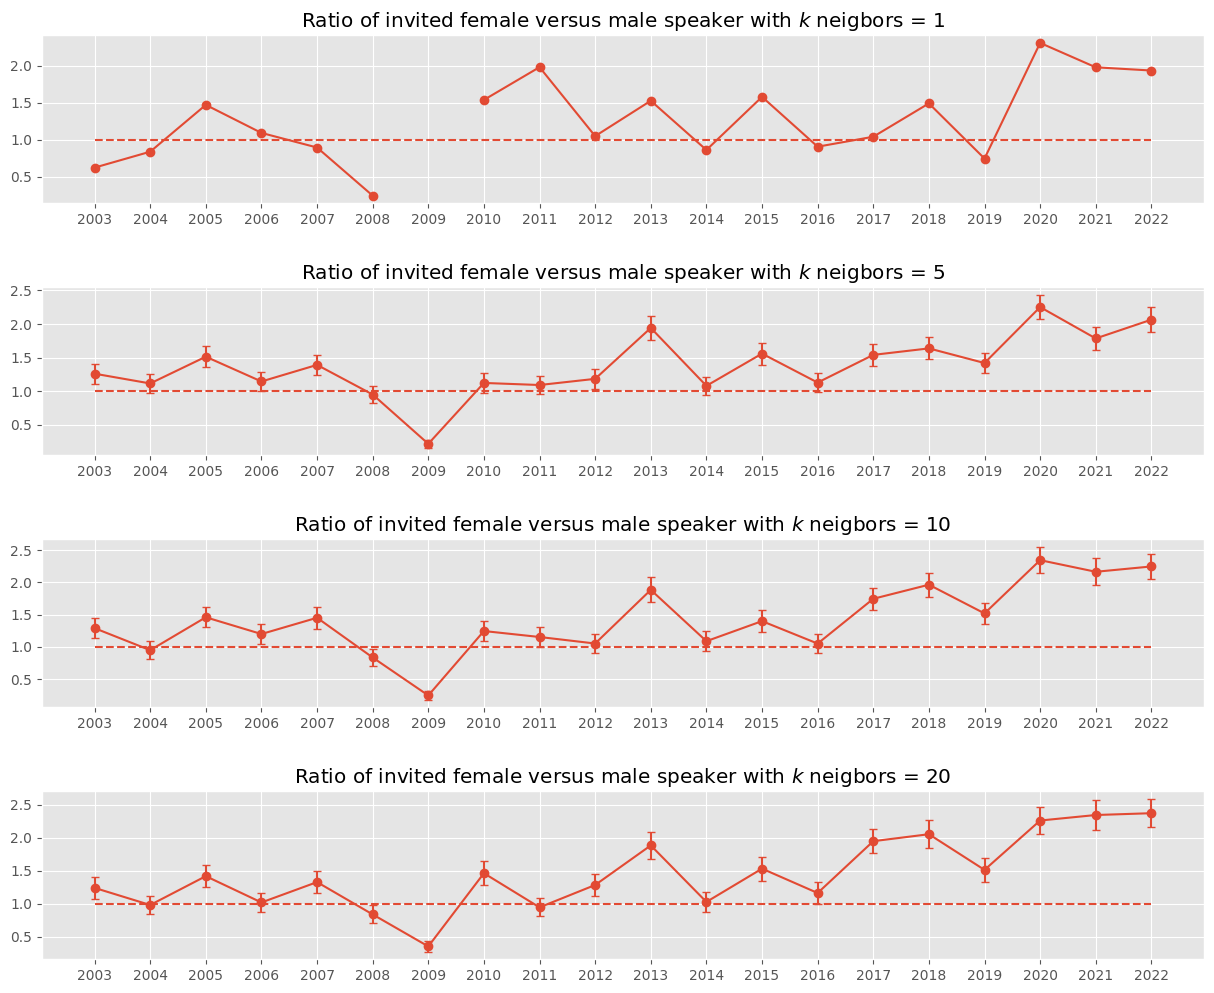

In [38]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
k_list = [1,5,10,20]

for n, k in enumerate(k_list):
    ax = plt.subplot(len(k_list), 1, n + 1)
    # ax.plot(df['Age'],'o',alpha=0.1)
    
    ratio_list = []
    std_list = []
    for year in tqdm(range(2003,2023)):
        try:
            df_year = df[df['Year'] == year]
            mean_ratio, std_ratio = Nearest_Neighbor(df_year,k=k, q=0.9, n=1000, print_results=False)
            ratio_list.append(mean_ratio)
            std_list.append(std_ratio)
        except: 
            ratio_list.append(np.NaN)
            std_list.append(np.NaN)
            continue
        
    ax.errorbar(range(2003,2023), ratio_list, yerr=std_list, fmt='o-', capsize=3,label="Adj. Ratio")
    ax.set_title('Ratio of invited female versus male speaker with $k$ neigbors = ' + str(k))
    ax.set_xticks(range(2003,2023,1))
    ax.hlines(1, 2003, 2022, linestyles='dashed')
    

## Heatmap 3D

In [41]:
ratio_list = []
for year in tqdm(range(2003,2023)):
    for age in df['Age Group'].unique(): 
        df_filtered = df[(df['Age Group'] == age) & (df['Year'] == year)]
        
        ratio_mean, _ = Nearest_Neighbor(df_filtered, k=10, q=0.9, n=1000, print_results=False)
        ratio_list.append(ratio_mean)
    
ratio_list = np.array(ratio_list).reshape(20,5)
# ratio_list

100%|██████████| 20/20 [05:49<00:00, 17.46s/it]


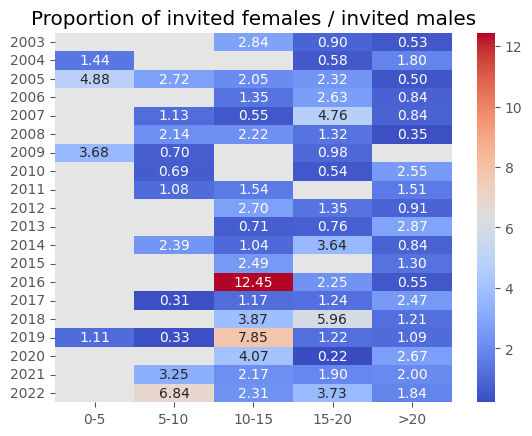

In [42]:
df_pivot = pd.DataFrame(ratio_list, columns=df['Age Group'].unique(), index=range(2003,2023))
age_group_order = ['0-5', '5-10', '10-15', '15-20', '>20']
df_pivot = df_pivot.reindex(columns=age_group_order)

# Plot
# plt.figure(figsize=(15, 12))
sns.heatmap(df_pivot, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Proportion of invited females / invited males')
plt.show()

## Heatmap 2D (age group)

In [50]:
ratio_list = []
age_group_order = ['0-5', '5-10', '10-15', '15-20', '>20']
for age in tqdm(age_group_order):
    df_filtered = df[df['Age Group'] == age]
    
    ratio_mean, _ = Nearest_Neighbor(df_filtered, k=10, q=0.9, n=1000, print_results=False)
    ratio_list.append(ratio_mean)
    
# ratio_list = np.array(ratio_list).reshape(20,5)
# ratio_list

100%|██████████| 5/5 [04:48<00:00, 57.76s/it]


<function matplotlib.pyplot.show(close=None, block=None)>

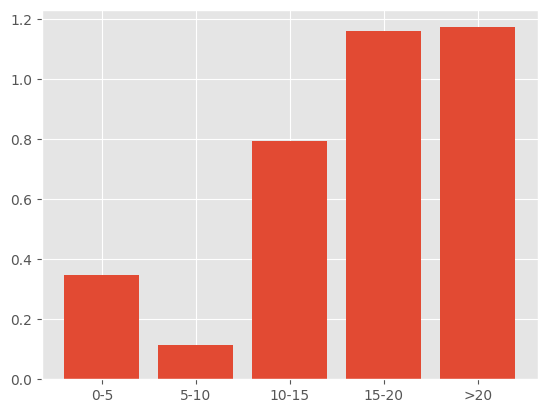

In [53]:
plt.bar(age_group_order,ratio_list)
plt.show

# Similarity on source

In [105]:
df_inv = df[df['Source'] == 'Invited'].reset_index(drop=True)
df_pro = df[df['Source'] == 'Proceedings']

nbrs = NearestNeighbors(n_neighbors=5).fit(df_inv[['log(Paper Count)','Productivity','Age']])
distances, indices = nbrs.kneighbors(df_pro[['log(Paper Count)','Productivity','Age']])

# Find threshold
threshold = np.quantile(distances.flatten(),q=0.7)
# plt.hist(distances.flatten(),bins=100)
# plt.vlines(threshold,0,1000)
# plt.show()
mask = distances <= threshold
# if print_results == True:
#     print('Threshold',threshold)
#     print('Pct. of indices I keep',mask.flatten()[mask.flatten() == True].shape[0] / mask.flatten().shape[0])

filtered_indices = indices.copy().astype(float)
filtered_indices[~mask] = np.nan
filtered_indices

array([[ 482.,  216.,  214.,  792.,  730.],
       [  nan,   nan,   nan,   nan,   nan],
       [ 438., 1112.,  295., 1034.,  475.],
       ...,
       [  81.,  217., 1044.,  480.,  685.],
       [ 797., 1093.,  316.,  669.,   78.],
       [1039.,  691.,   40.,  229., 1138.]])

In [106]:
mean_list = []
for i in tqdm(range(0,len(indices))):
    try:
        mean = df_inv.loc[indices[i],'gender'].value_counts(normalize=True)['F']
        mean_list.append(mean)
    except:
        mean_list.append(np.nan)
        continue

100%|██████████| 178823/178823 [01:10<00:00, 2528.63it/s]


In [107]:
df_pro['ratio'] = mean_list

In [108]:
np.nanmean(mean_list)

0.37103114713573854

<AxesSubplot: >

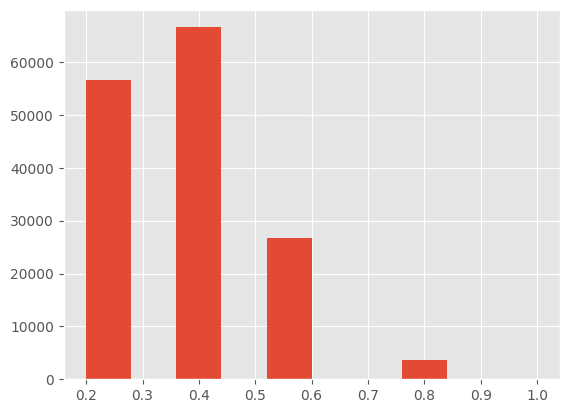

In [110]:
df_pro['ratio'].hist(bins=10)